In [3]:
#import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50


from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dense, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate , ReLU 

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-09-02 04:12:02.411329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756786322.583418      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756786322.633915      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [4]:
def create_df (d):
    imgs =  glob(f'{d}/*/*jpg*')

    label_map ={
        "MildDemented" :0 ,
        "ModerateDemented" :1,
        "NonDemented" : 2,
        "VeryMildDemented":3,
        
    }

    df = pd.DataFrame({
        'imgs': imgs,
        'label': [label_map[os.path.basename(os.path.dirname(path))] for path in imgs]
    })
    
    
    print( df.shape)
    return df


def split_df ( df):

    train_df , temp = train_test_split(df  , train_size = 0.8 , random_state =42 , stratify=df['label'])
    test_df , val_df = train_test_split(temp  , train_size = 0.5 , random_state =42 , stratify=temp['label'])
    
    return  train_df,val_df,test_df
    


In [10]:
def gen (df , aug_dict , img_size = (256 , 256) , batches = 32):

    img_gen = ImageDataGenerator(rescale=1./255, **aug_dict)

    generator = img_gen.flow_from_dataframe(
        df, 
        x_col = 'imgs',
        y_col='label',

        color_mode= 'rgb',
        target_size = img_size,
        batch_size = batches , 
        class_mode='raw',   # returns numeric labels as they are in df

        shuffle=True


    )

    return generator


In [6]:
def resnet50(img_size=(256,256,3), num_classes=4):
    
    # Load pretrained ResNet50 (exclude top FC layers)
    model = tf.keras.models.load_model("/kaggle/input/resnet50-10/tensorflow2/default/1/resnet50.keras")


    for layer in model.layers:
        layer.trainable = False
    
    # Unfreeze last N layers
    for layer in model.layers[-60:]:
        layer.trainable = True
        
    trainable_count = sum([1 for layer in model.layers if layer.trainable])
    print(f"Trainable layers: {trainable_count}/{len(model.layers)}")


    
    model.compile(optimizer=Adam(learning_rate=1e-4),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

    return model


In [7]:
def train (train_df , val_df , imgsize , batches ,epochs ,aug, num_classes = 4):

    model = resnet50()

    train_gen = gen(train_df , aug )
    val_gen = gen(val_df , {} )

    callbacks = [
        ModelCheckpoint('resnet50.keras', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        EarlyStopping ( monitor='val_loss', patience  =20 )
    ] 

    train_steps = len(train_df) // batches
    val_steps = len(val_df) // batches
    print(f"Training steps: {train_steps}, Validation steps: {val_steps}")

    
    history = model.fit(
        train_gen , 
        steps_per_epoch = train_steps,
        epochs = epochs ,

        batch_size = batches,
        validation_data = val_gen,
        validation_steps = val_steps,
        callbacks =callbacks,
        verbose=1
          
    )

    return history  , model

In [11]:
img_dir = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images/"

df = create_df (img_dir)

train_df,val_df,test_df = split_df(df)

aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
history , model = train ( train_df , val_df , (256,256) , 32 ,20 ,aug_dict, num_classes = 4)


(44000, 2)
Trainable layers: 60/180
Found 35200 validated image filenames.
Found 4400 validated image filenames.
Training steps: 1100, Validation steps: 137
Epoch 1/20


I0000 00:00:1756786490.489262      97 service.cc:148] XLA service 0x7cf9d0004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756786490.490004      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756786493.215524      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1100 ━━━━━━━━━━━━━━━━━━━━ 11:09:12 37s/step - accuracy: 0.8750 - loss: 0.2419

I0000 00:00:1756786503.833625      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8958 - loss: 0.2573
Epoch 1: val_loss improved from inf to 0.21918, saving model to resnet50.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 709s 612ms/step - accuracy: 0.8958 - loss: 0.2573 - val_accuracy: 0.9106 - val_loss: 0.2192 - learning_rate: 1.0000e-04
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9185 - loss: 0.2066
Epoch 2: val_loss improved from 0.21918 to 0.18241, saving model to resnet50.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 481s 437ms/step - accuracy: 0.9185 - loss: 0.2066 - val_accuracy: 0.9320 - val_loss: 0.1824 - learning_rate: 1.0000e-04
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9399 - loss: 0.1578
Epoch 3: val_loss improved from 0.18241 to 0.15858, saving model to resnet50.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 484s 440ms/step - accuracy: 0.9399 - loss: 0.1578 - val_accuracy: 0.9448 - val_loss: 0.1586 - learning_rate: 1.0000e-04
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 0

In [12]:
test_gen = gen (test_df , {})
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

val_gen = gen (val_df , {})
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

train_gen = gen (train_df , {})
test_loss, test_acc = model.evaluate(train_gen, verbose=1)
print(f"Train Accuracy: {test_acc:.4f}")
print(f"Train Loss: {test_loss:.4f}")

Found 4400 validated image filenames.
138/138 ━━━━━━━━━━━━━━━━━━━━ 34s 245ms/step - accuracy: 0.9865 - loss: 0.0331
Test Accuracy: 0.9898
Test Loss: 0.0297
Found 4400 validated image filenames.
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9838 - loss: 0.0507
Validation Accuracy: 0.9830
Validation Loss: 0.0517
Found 35200 validated image filenames.
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - accuracy: 0.9961 - loss: 0.0111
Train Accuracy: 0.9961
Train Loss: 0.0107


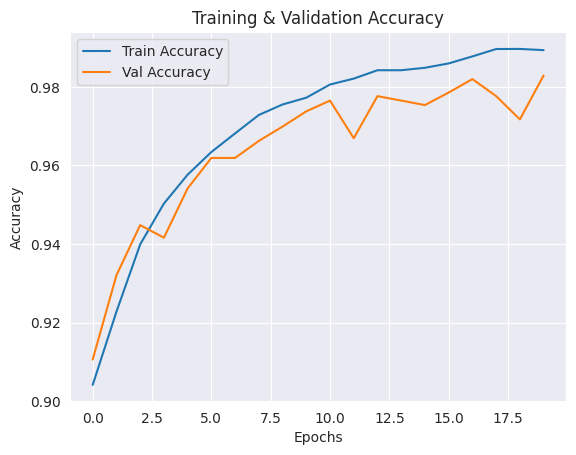

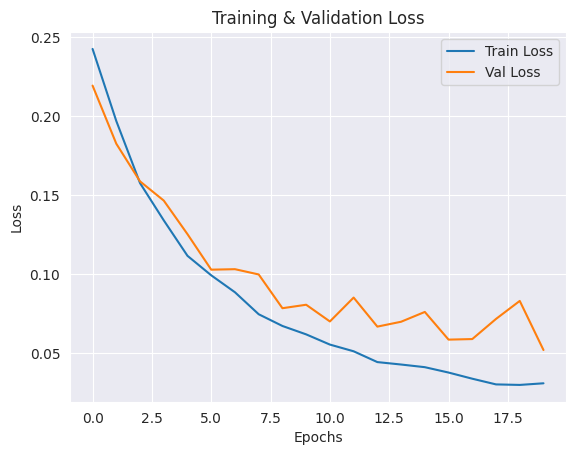

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.show()

# Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.show()